## Projet 10: Application de recommandation de contenu
### Partie 2: Modèlisation 

### 1. Import

#### 1.1 Import the libraries

In [152]:
from heapq import nlargest
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from math import *

import pickle

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from surprise import Dataset, Reader, SVD, accuracy, dump
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

#### 1.2 Import donéées

In [153]:
data_path = "../data/raw/globocom/"
clicks_path= "../data/raw/globocom/clicks/"

In [117]:
articles_df = pd.read_csv(data_path + 'articles_metadata.csv')
articles_df.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [64]:
articles_emb = pd.read_pickle(data_path + 'articles_embeddings.pickle')
articles_emb = pd.DataFrame(articles_emb, columns=["embedding_" + str(i) for i in range(articles_emb.shape[1])])
articles_emb.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [65]:
pca = PCA(n_components=50)
pca.fit(articles_emb)
articles_emb_trans_pca = pca.transform(articles_emb)

In [70]:
articles_emb_trans_pca = pd.DataFrame(articles_emb_trans_pca, columns=["embedding_" + str(i) for i in range(articles_emb_trans_pca.shape[1])])
articles_emb_trans_pca.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49
0,-2.176782,1.316913,-1.029048,0.901908,-1.809542,-2.064713,-1.221915,-0.024441,0.927261,-0.669806,...,0.100282,-0.901473,-0.409361,0.724184,-0.267678,0.060351,-0.089947,-0.107738,-0.156112,0.098132
1,-1.735174,-0.489893,3.268562,0.087855,1.473059,-0.932711,1.841631,-0.881798,-0.207201,0.816809,...,-0.219266,0.536258,-0.345674,0.234225,-0.314745,0.330480,-0.544971,-0.310859,0.207498,0.058546
2,-0.912688,2.089339,1.865869,-1.202519,2.530600,-0.521970,0.224352,1.479935,-0.191900,1.356800,...,0.760382,0.576442,-1.006015,-0.249962,0.012135,0.488646,-0.312057,0.181440,0.446842,0.075688
3,1.096567,-0.212955,4.183517,-0.649575,-0.130867,1.126555,1.063997,-0.662875,0.348143,1.463898,...,0.584634,0.377421,-0.315410,0.435518,-0.041553,0.447303,-0.178352,-0.255310,0.092584,0.544007
4,0.193785,0.263949,1.896583,-1.834345,1.270377,-1.723296,0.329006,0.283794,-0.659809,1.223740,...,0.172254,1.573488,-0.264647,0.111266,-1.088536,0.247204,-0.418065,-0.391187,-0.186283,0.012685


In [66]:
sum(pca.explained_variance_ratio_)

0.9452987434342504

In [38]:
def get_all_files_clicks(path):
    clicks_df = pd.DataFrame()
    for file in os.listdir(path):
        df = pd.read_csv(path + file)
        clicks_df = pd.concat([clicks_df, df], axis=0)

    return clicks_df

In [118]:
df_clicks = get_all_files_clicks(clicks_path)

In [119]:
df_clicks

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,15107,1507872960434128,1507872960000,4,20691,1507873325254,4,4,2,1,14,1
1308,15107,1507872960434128,1507872960000,4,327984,1507873616575,4,4,2,1,14,1
1309,15107,1507872960434128,1507872960000,4,172760,1507873646575,4,4,2,1,14,1
1310,294270,1507872968214129,1507872968000,2,96210,1507873274995,4,3,2,1,25,2


In [41]:
clicks_df = df_clicks[['user_id', 'session_id', 'session_size', 'click_article_id']]
clicks_df.head()

,user_id,session_id,session_size,click_article_id
0,93863,1507865792177843,2,96210
1,93863,1507865792177843,2,158094
2,294036,1507865795185844,2,20691
3,294036,1507865795185844,2,96210
4,77136,1507865796257845,2,336245


In [42]:
users_df = clicks_df.groupby('user_id').agg({'click_article_id':lambda x: list(x)})
users_df.head()

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[327984, 183176, 235840, 96663, 59758, 160474,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236444, 234318, 233688, 237452, 235745, 12096..."
4,"[336499, 271261, 48915, 44488, 195887, 195084,..."


In [71]:
def contentBasedRecommendArticle(articles, clicks, user_id, n=5):

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"

    articles_read_embedding = articles.loc[articles_read]

    articles = articles.drop(articles_read)

    matrix = cosine_similarity(articles_read_embedding, articles)

    rec = []

    for i in range(n):
        coord_x = floor(np.argmax(matrix)/matrix.shape[1])
        coord_y = np.argmax(matrix)%matrix.shape[1]

        rec.append(int(articles.index[coord_y]))

        matrix[coord_x][coord_y] = 0

    return rec

In [100]:
from sklearn.metrics.pairwise import cosine_similarity
from math import floor
import numpy as np

def contentBasedRecommendArticle(articles, clicks, user_id, n=5):
    # Get the articles read by the user
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    # If the user hasn't read any articles, recommend the most popular ones
    if len(articles_read) == 0:
        most_popular_articles = clicks['click_article_id'].value_counts().index.tolist()
        return most_popular_articles[:n]

    # Get the embeddings of the articles read by the user
    articles_read_embedding = articles.loc[articles_read]

    # Remove the articles read by the user from the list of articles
    articles = articles.drop(articles_read)

    # Calculate the cosine similarity between the articles read by the user and the other articles
    matrix = cosine_similarity(articles_read_embedding, articles)

    rec = []

    # Recommend the articles most similar to the articles read by the user
    for i in range(n):
        coord_x = floor(np.argmax(matrix)/matrix.shape[1])
        coord_y = np.argmax(matrix)%matrix.shape[1]

        rec.append(int(articles.index[coord_y]))

        # Set the similarity of the recommended article to 0
        matrix[coord_x][coord_y] = 0

    return rec

In [101]:
# Avec le fichier d'embedding classique
test_cb = contentBasedRecommendArticle(articles_emb, clicks_df, 5)
print(test_cb)

[157015, 284603, 62627, 62630, 224354]


In [102]:
# Avec le fichier d'embedding réduit après l'ACP
test_cb_acp = contentBasedRecommendArticle(articles_emb_trans_pca, clicks_df, 5)
print(test_cb_acp)

[157015, 62630, 62627, 284603, 224354]


In [103]:
def calculRatingByClick(clicks):

    count_user_article_size = (clicks.groupby(['user_id', "click_article_id"]).agg(user_article_size=("session_size", "sum")))
    count_user_total_size = (clicks.groupby(['user_id']).agg(user_total_size=("session_size", "sum")))

    ratings = count_user_article_size.join(count_user_total_size, on="user_id")

    ratings['rating'] = ratings['user_article_size'] / ratings['user_total_size']

    ratings = ratings.reset_index().drop(['user_article_size', 'user_total_size'], axis = 1).rename({'click_article_id': 'article_id'}, axis = 1)

    return ratings

In [106]:
ratings = calculRatingByClick(clicks_df)

ratings

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125
...,...,...,...
2950705,322894,168401,0.5
2950706,322895,63746,0.5
2950707,322895,289197,0.5
2950708,322896,30760,0.5


In [107]:
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(ratings.sample(frac=0.1, random_state=42), reader=reader)

param_grid = {'n_factors': [20, 50], 'n_epochs': [10, 20],
              'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.04]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [108]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.12529080767242992
{'n_factors': 20, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}


In [109]:
data = Dataset.load_from_df(ratings, reader=reader)

trainset = data.build_full_trainset()

model_SVD = gs.best_estimator['rmse']

model_SVD.fit(trainset)

In [81]:
# Sauvegarde du modèle
data_model = 'model'
model_filename = "model_svd.pickle"

list_dir = os.listdir('../data/')

if data_model not in list_dir:
    os.mkdir('../data/' + data_model)

dump.dump('../data/' + data_model + '/' + model_filename, algo=model_SVD)

In [82]:
model_SVD.predict(5, 158536, verbose=True)

user: 5          item: 158536     r_ui = None   est = 0.03   {'was_impossible': False}


Prediction(uid=5, iid=158536, r_ui=None, est=0.03402083711267999, details={'was_impossible': False})

In [83]:
def collaborativeFilteringRecommendArticle(articles, clicks, user_id, n=5):

    index = list(articles.index)

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    for ele in articles_read:
        if ele in index:
            index.remove(ele)

    results = dict()

    for i in index:
        pred = model_SVD.predict(user_id, i)
        results[pred.iid] = pred.est
    
    return nlargest(n, results, key = results.get)

In [84]:
test_cf = collaborativeFilteringRecommendArticle(articles_emb, clicks_df, 5, 5)
print(test_cf)

[289003, 331116, 202355, 218028, 336254]


In [85]:
test_cf = collaborativeFilteringRecommendArticle(articles_emb, clicks_df, 120, 5)
print(test_cf)

[277107, 331116, 202355, 218028, 336254]


In [91]:
nb_clicks = clicks_df.groupby('click_article_id').agg({'user_id': 'count'}).rename(columns={'user_id': 'nb_clicks'}).reset_index()
nb_clicks = nb_clicks.sort_values(by='nb_clicks', ascending=False)
article_ids = [289003, 331116, 202355, 218028, 336254]
positions = nb_clicks[nb_clicks['click_article_id'].isin(article_ids)].index.tolist()
print(positions)

[42587, 43115, 38021, 26919, 29098]


<Axes: xlabel='click_article_id'>

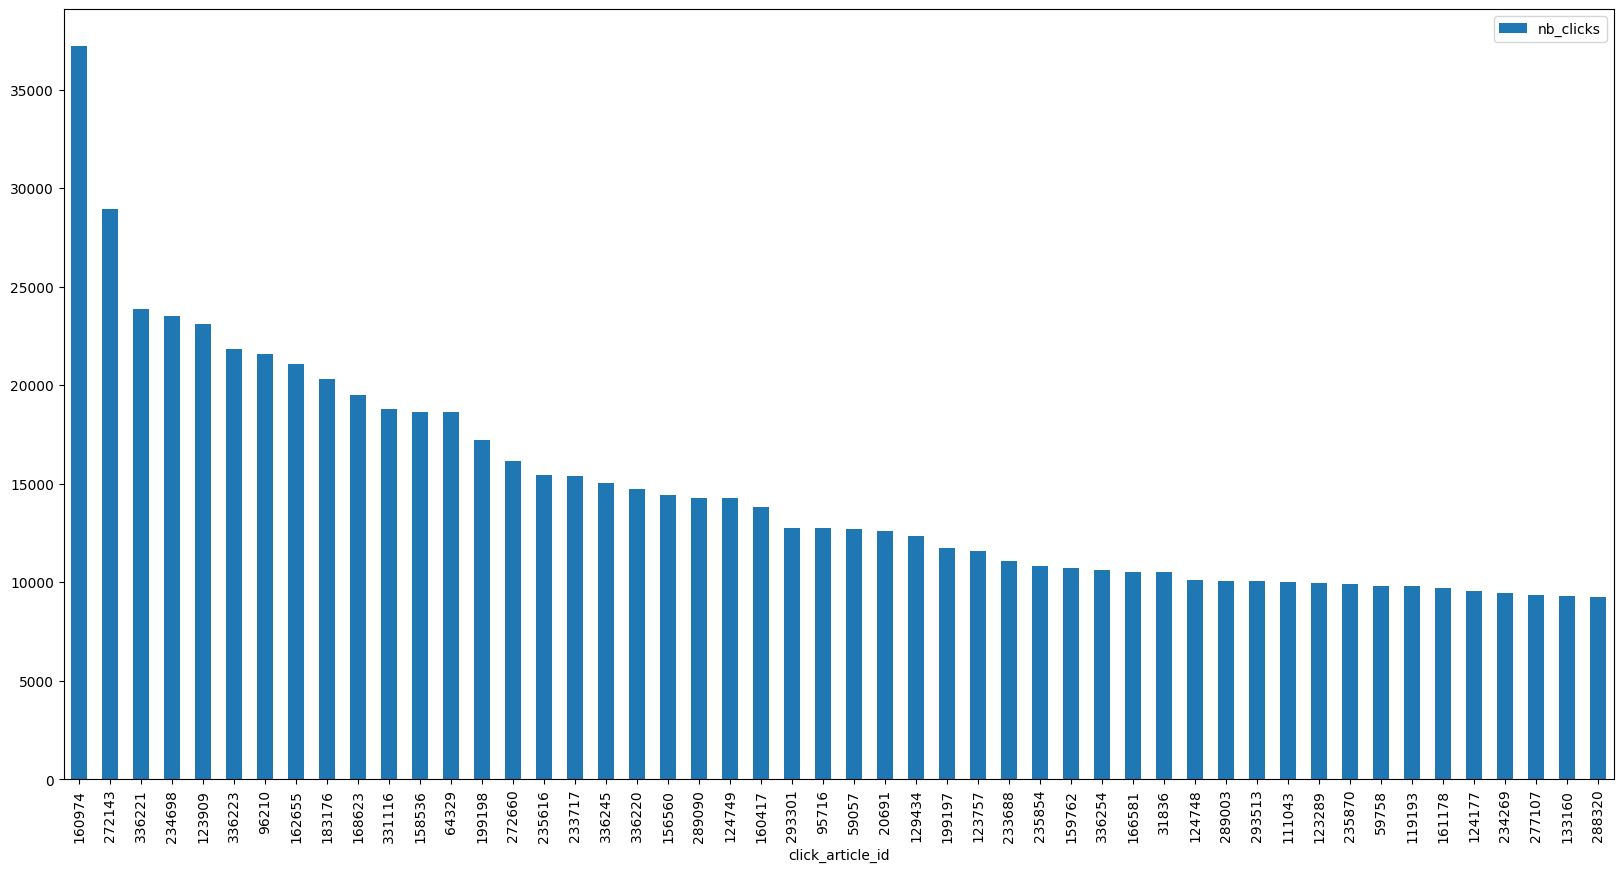

In [89]:
nb_clicks.plot.bar(x='click_article_id', y='nb_clicks', figsize=(20, 10))

### Test 2

In [95]:

from scipy.spatial import distance

from random import randint

def recommandationArticle(embedding, userId, n=5):
    embedding_temp = embedding
    # on récupére tout les article lu par l'utilisateurs
    var = clicks_df.loc[clicks_df['user_id']==userId]['click_article_id']
    # on choisi un article simillaire au article lu par l'utilisateurs
    if len(var) == 0:
        # Si il n'a pas encore lu d'article on lui propose par rapport à l'article le plus populaire
        value = clicks_df.groupby("click_article_id")["click_article_id"].size().sort_values(ascending=False).index[0]
    else:
        value = randint(0, len(var))
    # On supprime les article déjà lu par l'utilisateur
    for i in range(0, len(var)):
        if i != value:
            embedding_temp = np.delete(embedding_temp, [i], 0)
    
    arr = []
    
    # on supprime l'article selectionné
    f = np.delete(embedding_temp, [value], 0)
    
    # on récupére les n articles les plus similaire à celui selectionné
    for i in range(0, n):
        # On récupére la matrice de distance
        distances = distance.cdist([embedding_temp[value]], f, "cosine")[0]
        min_index = np.argmin(distances)
        f = np.delete(f, [min_index], 0)
        result = np.where(embedding==f[min_index])
        arr.append(result[0][0])
        
    return arr

In [99]:
recommandationArticle(articles_emb, 5)

[604, 756, 1036, 1307, 1651]

In [124]:
df = df_clicks.merge(articles_df,left_on="click_article_id",right_on="article_id")

In [125]:
print("Il y a un total de",df[df["created_at_ts"] > df["click_timestamp"]]["article_id"].nunique(),"article qui on était mise à jour ultérieurement à une interaction.")

Il y a un total de 1052 article qui on était mise à jour ultérieurement à une interaction.


In [123]:
clicks_df

,user_id,session_id,session_size,click_article_id
0,93863,1507865792177843,2,96210
1,93863,1507865792177843,2,158094
2,294036,1507865795185844,2,20691
3,294036,1507865795185844,2,96210
4,77136,1507865796257845,2,336245
...,...,...,...,...
1307,15107,1507872960434128,4,20691
1308,15107,1507872960434128,4,327984
1309,15107,1507872960434128,4,172760
1310,294270,1507872968214129,2,96210
